[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting the process...
Dataset loaded successfully.
The dataset has 3137 rows and 2 columns.

--- First 5 rows of the raw data ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Cleaning and preprocessing all the movie reviews...
Preprocessing complete.

--- First 5 rows after cleaning ---
                                              review sentiment
0  one reviewer mentioned watching oz episode you...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically there family little boy jake think t...  negative
4  petter matteis love time money visually stunni...  positiv

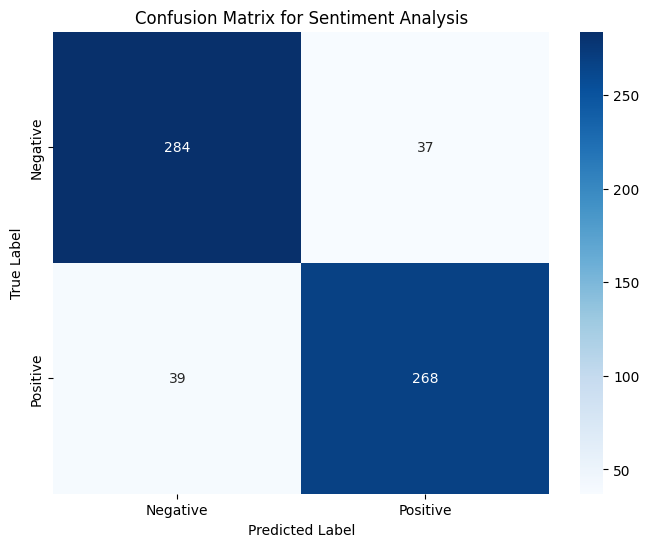


Process finished!


In [7]:
# ---
# My Submission for the IMDb Sentiment Analysis Task
# ---

# === 1. SETUP: IMPORTING THE NECESSARY LIBRARIES ===
# I'll need pandas for data handling, scikit-learn for the ML parts, and nltk for text processing.
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Download the specific NLTK packages we need for text cleaning
nltk.download('stopwords')
nltk.download('wordnet')

# === 2. DATA LOADING AND INITIAL INSPECTION ===
print("Starting the process...")
# Using the robust 'python' engine and skipping bad lines to handle file errors.
try:
    reviews_df = pd.read_csv('IMDB Dataset.csv', engine='python', on_bad_lines='skip')
    print("Dataset loaded successfully.")
    print(f"The dataset has {reviews_df.shape[0]} rows and {reviews_df.shape[1]} columns.")
except FileNotFoundError:
    print("Error: 'IMDB Dataset.csv' not found. Please make sure it's uploaded to Colab.")

# Let's look at the first few rows to see what we're dealing with.
print("\n--- First 5 rows of the raw data ---")
print(reviews_df.head())

# === 3. TEXT PREPROCESSING AND CLEANING ===
# This is a crucial step to prepare the text for the model.
# I'll convert to lowercase, remove HTML/punctuation, and then use lemmatization to get the root of words.

lemmatizer = WordNetLemmatizer()
english_stop_words = set(stopwords.words('english'))

def clean_review_text(text):
    # Check if the text is a valid string, otherwise return empty
    if not isinstance(text, str):
        return ""

    # Simple cleaning: lowercase and remove HTML tags/punctuation
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization: split the review into a list of words
    words = text.split()

    # Advanced cleaning: remove stopwords and lemmatize
    # This helps the model focus on the words that carry the most meaning.
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in english_stop_words]

    return " ".join(cleaned_words)

print("\nCleaning and preprocessing all the movie reviews...")
reviews_df['review'] = reviews_df['review'].apply(clean_review_text)
print("Preprocessing complete.")

# Let's check the data again after cleaning
print("\n--- First 5 rows after cleaning ---")
print(reviews_df.head())


# === 4. PREPARING DATA FOR THE MODEL ===
# The model needs numerical data, so I'll convert sentiments to 1s and 0s.
reviews_df['sentiment'] = reviews_df['sentiment'].map({'positive': 1, 'negative': 0})

# Separate the features (the reviews) from the labels (the sentiment)
features = reviews_df['review']
labels = reviews_df['sentiment']

# Split the data into a training set (80%) and a testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"\nData has been split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# === 5. FEATURE EXTRACTION (TF-IDF VECTORIZATION) ===
# Now, I'll convert the cleaned text into numerical vectors using TF-IDF.
# This method is smart because it gives higher weight to more important words.
# I'm also using n-grams (1, 2) to capture pairs of words like "not good".
print("\nConverting text data to numerical vectors with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# Learn the vocabulary from the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Use the same vocabulary to transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print("Vectorization complete.")
print(f"The vocabulary size is {len(tfidf_vectorizer.get_feature_names_out())} features.")


# === 6. MODEL TRAINING AND EVALUATION ===
# Time to train the models and see how they perform!

# --- Model A: Logistic Regression ---
print("\n--- Training the Logistic Regression Classifier ---")
logistic_classifier = LogisticRegression(solver='liblinear', C=1.0)
logistic_classifier.fit(X_train_tfidf, y_train)
predictions_lr = logistic_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, predictions_lr)
print(f"Logistic Regression Final Accuracy: {accuracy_lr:.4f}")
print("Classification Report:")
print(classification_report(y_test, predictions_lr))

# --- Model B: Linear Support Vector Classifier (SVC) ---
print("\n--- Training the Linear SVC Classifier ---")
svm_classifier = LinearSVC(C=0.5, random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
predictions_svc = svm_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy_svc = accuracy_score(y_test, predictions_svc)
print(f"Linear SVC Final Accuracy: {accuracy_svc:.4f}")
print("Classification Report:")
print(classification_report(y_test, predictions_svc))
# ---
# FINAL POLISH: VISUALIZING THE MODEL'S PERFORMANCE
# ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# We'll visualize the results of our best model: the Logistic Regression Classifier
print("--- Generating Confusion Matrix for the Logistic Regression Model ---")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions_lr)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()
print("\nProcess finished!")